In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [30]:
# Set up hyper parameters
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000 

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json\
    -O /tmp/sarcasm.json

--2020-08-05 06:21:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  32.1MB/s    in 0.2s    

2020-08-05 06:21:57 (32.1 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [31]:
# open dataset and load it as iterable 

with open('/tmp/sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [32]:
# split into training and validation set
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [33]:
# sequence dataset and pad those sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [34]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [35]:
# Define model 
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(10000, 16, input_length=max_length), 
                             tf.keras.layers.GlobalAveragePooling1D(), 
                             tf.keras.layers.Dense(24, activation = 'relu'), 
                             tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [36]:
# Compile model 
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [38]:
# train model 
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data = (testing_padded, testing_labels), verbose = 2)

Epoch 1/30
625/625 - 3s - loss: 0.6747 - accuracy: 0.5717 - val_loss: 0.6254 - val_accuracy: 0.6148
Epoch 2/30
625/625 - 2s - loss: 0.4707 - accuracy: 0.8159 - val_loss: 0.4078 - val_accuracy: 0.8256
Epoch 3/30
625/625 - 3s - loss: 0.3275 - accuracy: 0.8676 - val_loss: 0.3693 - val_accuracy: 0.8401
Epoch 4/30
625/625 - 3s - loss: 0.2738 - accuracy: 0.8927 - val_loss: 0.3457 - val_accuracy: 0.8557
Epoch 5/30
625/625 - 3s - loss: 0.2368 - accuracy: 0.9079 - val_loss: 0.3478 - val_accuracy: 0.8509
Epoch 6/30
625/625 - 2s - loss: 0.2077 - accuracy: 0.9204 - val_loss: 0.3481 - val_accuracy: 0.8571
Epoch 7/30
625/625 - 3s - loss: 0.1848 - accuracy: 0.9302 - val_loss: 0.3572 - val_accuracy: 0.8556
Epoch 8/30
625/625 - 3s - loss: 0.1663 - accuracy: 0.9374 - val_loss: 0.3749 - val_accuracy: 0.8517
Epoch 9/30
625/625 - 3s - loss: 0.1505 - accuracy: 0.9445 - val_loss: 0.3843 - val_accuracy: 0.8539
Epoch 10/30
625/625 - 2s - loss: 0.1362 - accuracy: 0.9503 - val_loss: 0.4078 - val_accuracy: 0.8475

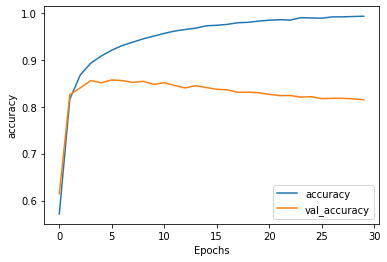

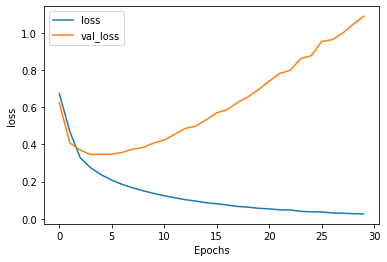

In [39]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [40]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [41]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [42]:
import io

out_v = io.open('vecs2.tsv', 'w', encoding='utf-8')
out_m = io.open('meta2.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

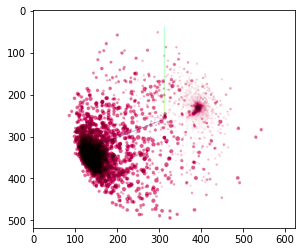

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('/content/img2.png')
plt.imshow(img)

In [43]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.4861007e-01]
 [3.9913521e-06]]
